<a href="https://colab.research.google.com/github/Ry02024/24DXbyLifeIsTech/blob/main/%E8%AA%B2%E9%A1%8C04/%E8%AA%B2%E9%A1%8C04%EF%BC%88%E3%82%B7%E3%83%9F%E3%83%A5%E3%83%AC%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シミュレーション

## ライブラリのインポート

In [1]:
!git clone https://github.com/Ry02024/24DXbyLifeIsTech.git

Cloning into '24DXbyLifeIsTech'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 219 (delta 29), reused 7 (delta 7), pack-reused 164 (from 1)
Receiving objects: 100% (219/219), 26.91 MiB | 19.08 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
!pip install japanize-matplotlib -q
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
ls

24DXbyLifeIsTech/  sample_data/


In [5]:
%cd 24DXbyLifeIsTech
from Scripts import scenario_simulation
from Scripts import scenario_evaluation
%cd -

/content/24DXbyLifeIsTech
/content


## データの処理

### データの読み込み

In [6]:
data_dir = "/content/24DXbyLifeIsTech/Data/preprocessed"

In [7]:
ls {data_dir}

data_sales_preprocessed2.csv  data_sales_preprocessed.csv  data_survey_preprocessed.csv


In [8]:
sales_data = pd.read_csv(f"{data_dir}/data_sales_preprocessed2.csv")

In [9]:
sales_data

,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,日付,時間帯,売上
0,2020-04-01 09:32:25,入場料,8000181,入場料600円,600,NaN,8,2020-04-01,09:00:00,4800
1,2020-04-01 09:41:10,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,09:00:00,1200
2,2020-04-01 09:47:09,カフェ,8000152,セット 最中アイス・抹茶,900,266.0,1,2020-04-01,09:00:00,900
3,2020-04-01 09:47:09,入場料,8000181,入場料600円,600,NaN,1,2020-04-01,09:00:00,600
4,2020-04-01 10:16:25,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,10:00:00,1200
...,...,...,...,...,...,...,...,...,...,...
39328,2021-12-01 17:55:15,入場料,8000181,入場料600円,600,NaN,83,2021-12-01,17:00:00,49800
39329,2021-12-01 17:55:15,イベント,8000319,予約制入場手数料,200,NaN,33,2021-12-01,17:00:00,6600
39330,2021-12-02 09:00:39,カフェ,8000324,喫茶 800円,800,NaN,4,2021-12-02,09:00:00,3200
39331,2021-12-02 09:00:39,カフェ,8000325,抹茶 0円,0,NaN,4,2021-12-02,09:00:00,0


In [10]:
# Create new columns for '年', '月', '日', and '時間' from the '取引日時' column
data = sales_data.copy()
data['年'] = pd.to_datetime(sales_data['取引日時']).dt.year
data['月'] = pd.to_datetime(sales_data['取引日時']).dt.month
data['日'] = pd.to_datetime(sales_data['取引日時']).dt.day
data['時間'] = pd.to_datetime(sales_data['取引日時']).dt.hour

In [11]:
data

,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,日付,時間帯,売上,年,月,日,時間
0,2020-04-01 09:32:25,入場料,8000181,入場料600円,600,NaN,8,2020-04-01,09:00:00,4800,2020,4,1,9
1,2020-04-01 09:41:10,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,09:00:00,1200,2020,4,1,9
2,2020-04-01 09:47:09,カフェ,8000152,セット 最中アイス・抹茶,900,266.0,1,2020-04-01,09:00:00,900,2020,4,1,9
3,2020-04-01 09:47:09,入場料,8000181,入場料600円,600,NaN,1,2020-04-01,09:00:00,600,2020,4,1,9
4,2020-04-01 10:16:25,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,10:00:00,1200,2020,4,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39328,2021-12-01 17:55:15,入場料,8000181,入場料600円,600,NaN,83,2021-12-01,17:00:00,49800,2021,12,1,17
39329,2021-12-01 17:55:15,イベント,8000319,予約制入場手数料,200,NaN,33,2021-12-01,17:00:00,6600,2021,12,1,17
39330,2021-12-02 09:00:39,カフェ,8000324,喫茶 800円,800,NaN,4,2021-12-02,09:00:00,3200,2021,12,2,9
39331,2021-12-02 09:00:39,カフェ,8000325,抹茶 0円,0,NaN,4,2021-12-02,09:00:00,0,2021,12,2,9


In [12]:
# Define the COVID events date ranges
covid_events = [
    {"event": "第1回緊急事態宣言", "start": "2020-04-07", "end": "2020-05-25"},
    {"event": "Go To トラベルキャンペーン", "start": "2020-07-22", "end": "2020-12-28"},
    {"event": "第2回緊急事態宣言", "start": "2021-01-07", "end": "2021-03-21"},
    {"event": "第3回緊急事態宣言", "start": "2021-04-25", "end": "2021-06-20"},
    {"event": "コロナ禍のオリンピックにおける政府対応", "start": "2021-07-12", "end": "2021-09-30"}
]

# Convert the event start and end dates to datetime
for event in covid_events:
    event['start'] = pd.to_datetime(event['start'])
    event['end'] = pd.to_datetime(event['end'])

# Determine the earliest and latest dates of the events
start_of_covid = min(event['start'] for event in covid_events)
end_of_covid = max(event['end'] for event in covid_events)

In [13]:
data['日付'] = pd.to_datetime(data['日付'])
covid_period_data = data[(data['日付'] >= start_of_covid) & (data['日付'] <= end_of_covid)]

In [14]:
# Sort the data by date to ensure it's in chronological order
covid_period_data_sorted = covid_period_data.sort_values(by='日付')

# Split the data into 70% for training and 30% for testing, based on chronological order
split_index = int(len(covid_period_data_sorted) * 0.7)
covid_train_chronological = covid_period_data_sorted.iloc[:split_index]
covid_test_chronological = covid_period_data_sorted.iloc[split_index:]

# Get the date ranges after the chronological split
covid_train_chronological_dates = covid_train_chronological['日付'].min(), covid_train_chronological['日付'].max()
covid_test_chronological_dates = covid_test_chronological['日付'].min(), covid_test_chronological['日付'].max()

In [15]:
covid_train_chronological_dates, covid_test_chronological_dates

((Timestamp('2020-04-07 00:00:00'), Timestamp('2021-03-29 00:00:00')),
 (Timestamp('2021-03-29 00:00:00'), Timestamp('2021-09-29 00:00:00')))

In [16]:
# Define the cutoff date for the 70-30 split based on the COVID period's date range
covid_period_start = covid_period_data_sorted['日付'].min()
covid_period_end = covid_period_data_sorted['日付'].max()

# Calculate the split point date for the 70-30 split
cutoff_date = covid_period_start + 0.7 * (covid_period_end - covid_period_start)

# Split the data based on this cutoff date
covid_train_by_period = covid_period_data_sorted[covid_period_data_sorted['日付'] <= cutoff_date]
covid_test_by_period = covid_period_data_sorted[covid_period_data_sorted['日付'] > cutoff_date]

# Get the sizes of the split datasets
covid_train_by_period_size = covid_train_by_period.shape
covid_test_by_period_size = covid_test_by_period.shape

covid_train_by_period_size, covid_test_by_period_size, cutoff_date


((22567, 14), (6640, 14), Timestamp('2021-04-19 23:59:59.999999996'))

In [17]:
covid_test_by_period

,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,日付,時間帯,売上,年,月,日,時間
22927,2021-04-20 15:43:20,カフェ,8000325,抹茶 0円,0,NaN,2,2021-04-20,15:00:00,0,2021,4,20,15
22928,2021-04-20 15:55:47,カフェ,8000325,抹茶 0円,0,NaN,1,2021-04-20,15:00:00,0,2021,4,20,15
22933,2021-04-20 16:12:06,入場料,8000181,入場料600円,600,NaN,1,2021-04-20,16:00:00,600,2021,4,20,16
22930,2021-04-20 16:03:38,カフェ,8000327,クラフトビール 0円,0,NaN,1,2021-04-20,16:00:00,0,2021,4,20,16
22931,2021-04-20 16:03:38,カフェ,8000361,どら焼き 0円,0,NaN,1,2021-04-20,16:00:00,0,2021,4,20,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29510,2021-09-08 08:15:25,物販,8000422,紙袋,20,NaN,1,2021-09-08,08:00:00,20,2021,9,8,8
29511,2021-09-25 15:37:44,イベント,8000424,イベント_3800円,3800,NaN,27,2021-09-25,15:00:00,102600,2021,9,25,15
29512,2021-09-25 15:42:03,イベント,8000407,イベント_5000円,5000,NaN,10,2021-09-25,15:00:00,50000,2021,9,25,15
29513,2021-09-25 15:52:45,物販,8000425,菓子詰め合わせ小箱,1000,570.0,1,2021-09-25,15:00:00,1000,2021,9,25,15


In [18]:
# def date_data_preprocessing(df):
#     # --- 7. '取引日時' 列を基に '年', '月', '日', '時間' の新しい列を作成 ---
#     df['取引日時'] = pd.to_datetime(df['取引日時'])
#     df['年'] = df['取引日時'].dt.year
#     df['月'] = df['取引日時'].dt.month
#     df['日'] = df['取引日時'].dt.day
#     df['時間'] = df['取引日時'].dt.hour
#     df['日付'] = pd.to_datetime(df['日付'])
#     df.set_index('日付', inplace=True)
#     df.drop('取引日時', axis=1, inplace=True)
#     return df

In [19]:
# sales_df = date_data_preprocessing(sales_data)
# display(sales_df)

### シナリオアルゴリズムの作成（参照：[データ分析](https://colab.research.google.com/drive/1UyvZKhMyXKOSDXEnQKm3C3TcXkqjP3QE?usp=sharing)）

In [20]:
# シミュレーションの設定
price_increase = 1.2  # 20%の値上げ
target_categories = ['ガイド', '撮影料']  # 価格調整対象のカテゴリ
adjustment_time_period = ['17:00:00', '18:00:00']  # 夕方の時間帯で価格調整

# シミュレーションの実行
scenario_A = scenario_simulation.price_adjustment_simulation(covid_test_by_period, price_increase, target_categories, adjustment_time_period)

# 価格調整があった行のみを抽出（元の価格とシミュレーション後の商品単価が異なる行）
adjusted_prices_df = scenario_A[scenario_A['元の価格'] != scenario_A['シナリオの商品単価']]

# 調整があったデータを確認
adjusted_prices_df[['商品カテゴリ', '時間帯', '元の価格', 'シナリオの商品単価']]

,商品カテゴリ,時間帯,元の価格,シナリオの商品単価
24925,撮影料,17:00:00,30000,36000.0
25982,ガイド,17:00:00,11000,13200.0
25980,撮影料,17:00:00,30000,36000.0
26472,撮影料,17:00:00,30000,36000.0
29506,撮影料,18:00:00,36000,43200.0


In [21]:
# シミュレーションの設定
price_increase = 1.2  # 20%の値上げ
target_categories = ['ガイド', '撮影料']  # 価格調整対象のカテゴリ
adjustment_time_period = ['17:00:00', '18:00:00']  # 夕方の時間帯で価格調整

# シミュレーションの実行
scenario_A = price_adjustment_simulation(covid_test_by_period, price_increase, target_categories, adjustment_time_period)

# 価格調整があった行のみを抽出（元の価格とシミュレーション後の商品単価が異なる行）
adjusted_prices_df = scenario_A[scenario_A['元の価格'] != scenario_A['シナリオの商品単価']]

# 調整があったデータを確認
adjusted_prices_df[['商品カテゴリ', '時間帯', '元の価格', 'シナリオの商品単価']]

,商品カテゴリ,時間帯,元の価格,シナリオの商品単価
24925,撮影料,17:00:00,30000,36000.0
25982,ガイド,17:00:00,11000,13200.0
25980,撮影料,17:00:00,30000,36000.0
26472,撮影料,17:00:00,30000,36000.0
29506,撮影料,18:00:00,36000,43200.0


In [30]:
# シミュレーションBの設定
price_decrease = 0.9  # 10%の値下げ
target_categories_B = ['ガイド', '撮影料']  # 価格調整対象のカテゴリ
adjustment_time_period_B = ['09:00:00', '10:00:00', '11:00:00', '12:00:00', '18:00:00', '19:00:00']  # 夕方の時間帯で価格調整

# シミュレーションBの実行
scenario_B = price_adjustment_simulation(covid_test_by_period, price_decrease, target_categories_B, adjustment_time_period_B)

# 調整があった行のみを抽出（元の価格とシミュレーション後の商品単価が異なる行）
adjusted_prices_df_B = scenario_B[scenario_B['元の価格'] != scenario_B['シナリオの商品単価']]

# 調整があったデータを確認
adjusted_prices_df_B[['商品カテゴリ', '時間帯', '元の価格', 'シナリオの商品単価']]


,商品カテゴリ,時間帯,元の価格,シナリオの商品単価
24391,ガイド,09:00:00,11000,9900.0
26490,撮影料,12:00:00,100000,90000.0
27134,ガイド,10:00:00,11000,9900.0
29411,撮影料,09:00:00,30000,27000.0
29506,撮影料,18:00:00,36000,32400.0


In [ ]:
#シミュレーションA + B
scenario_AB = scenario_A.copy()
scenario_AB.loc[adjusted_prices_df_B.index] = scenario_B.loc[adjusted_prices_df_B.index]
# 調整が行われたデータを確認
adjusted_prices_df = scenario_AB[scenario_AB['元の価格'] != scenario_AB['シナリオの商品単価']]

# 結果を確認
adjusted_prices_df[['商品カテゴリ', '時間帯', '元の価格', 'シナリオの商品単価', '元の売上', 'シナリオの売上']]


## モデルの読み込み

In [21]:
model_dir = "/content/24DXbyLifeIsTech/Models/"
file_name = "lightgbm_model.txt"
model_path = f"{model_dir}{file_name}"

In [22]:
# 保存したモデルを読み込む
loaded_model = lgb.Booster(model_file=model_path)

# # 読み込んだモデルで予測
# y_pred_loaded = loaded_model.predict(X_test, num_iteration=loaded_model.best_iteration)

# # 結果の確認
# print(y_pred_loaded[:10])  # 最初の10件を表示

## シミュレーション

1. 設定の確認
1. 前処理
1. 予測

### シナリオA

In [23]:
scenario_A

,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,日付,時間帯,売上,年,月,日,時間,元の価格,シナリオの商品単価,元の売上
22927,2021-04-20 15:43:20,カフェ,8000325,抹茶 0円,0,NaN,2,2021-04-20,15:00:00,0,2021,4,20,15,0,0.0,0
22928,2021-04-20 15:55:47,カフェ,8000325,抹茶 0円,0,NaN,1,2021-04-20,15:00:00,0,2021,4,20,15,0,0.0,0
22933,2021-04-20 16:12:06,入場料,8000181,入場料600円,600,NaN,1,2021-04-20,16:00:00,600,2021,4,20,16,600,600.0,600
22930,2021-04-20 16:03:38,カフェ,8000327,クラフトビール 0円,0,NaN,1,2021-04-20,16:00:00,0,2021,4,20,16,0,0.0,0
22931,2021-04-20 16:03:38,カフェ,8000361,どら焼き 0円,0,NaN,1,2021-04-20,16:00:00,0,2021,4,20,16,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29510,2021-09-08 08:15:25,物販,8000422,紙袋,20,NaN,1,2021-09-08,08:00:00,20,2021,9,8,8,20,20.0,20
29511,2021-09-25 15:37:44,イベント,8000424,イベント_3800円,3800,NaN,27,2021-09-25,15:00:00,102600,2021,9,25,15,3800,3800.0,102600
29512,2021-09-25 15:42:03,イベント,8000407,イベント_5000円,5000,NaN,10,2021-09-25,15:00:00,50000,2021,9,25,15,5000,5000.0,50000
29513,2021-09-25 15:52:45,物販,8000425,菓子詰め合わせ小箱,1000,570.0,1,2021-09-25,15:00:00,1000,2021,9,25,15,1000,1000.0,1000


予測売上の合計: 8510448.08円
実売上の合計: 9094820.00円
売上の変化: -584371.92円


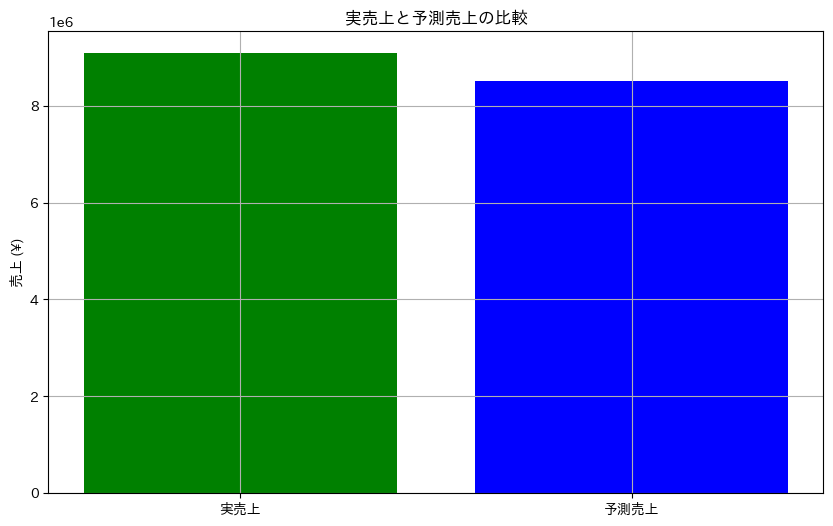

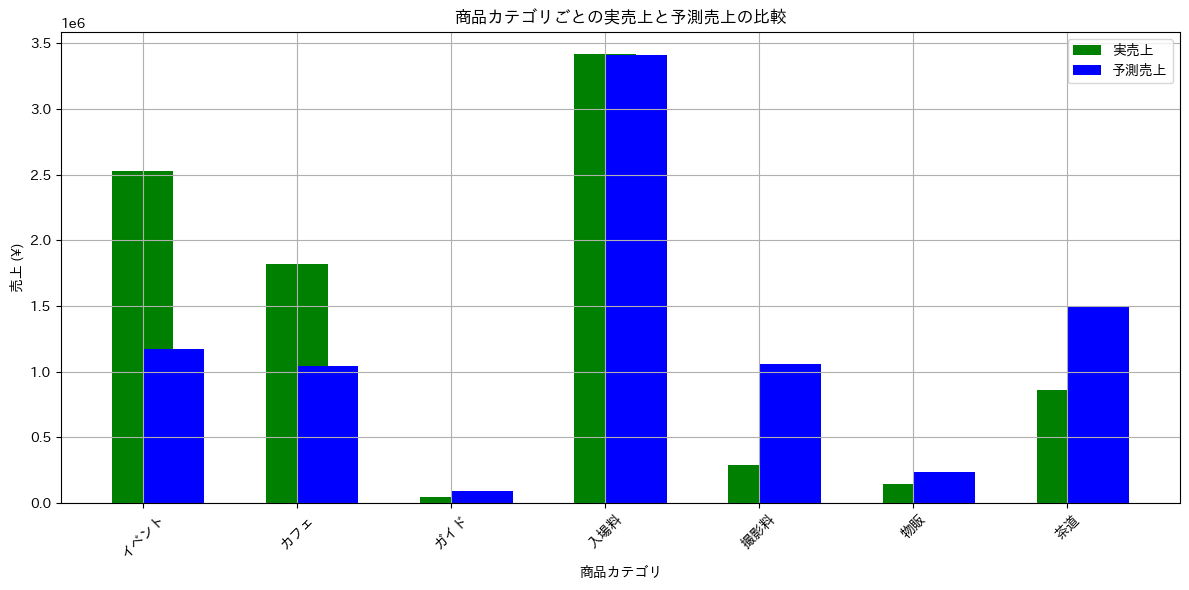

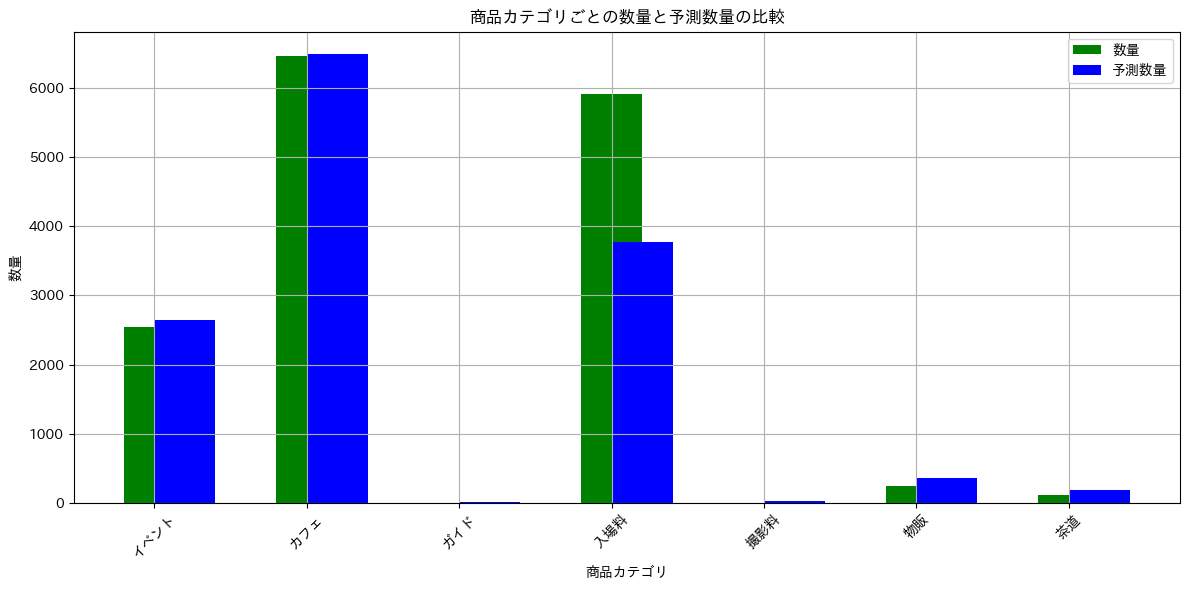

In [23]:
# scenario_simulation import sim
scenario_A4sim = scenario_A.copy()
selected_columns = ['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']
result = scenario_simulation.sim(scenario_A4sim, '/content/24DXbyLifeIsTech/Configs/config.yaml', loaded_model, selected_columns)

### 施策の評価

In [27]:
filtered_result = result[(result['商品カテゴリ'].isin(['ガイド', '撮影料']))][['商品カテゴリ', '商品単価', '数量', 'シナリオの商品単価', '予測数量']]
# シナリオ前の売上とシナリオ後の売上を計算して追加
filtered_result['シナリオ前の売上'] = filtered_result['商品単価'] * filtered_result['数量']
filtered_result['シナリオ後の売上'] = filtered_result['シナリオの商品単価'] * filtered_result['予測数量']
filtered_result

,商品カテゴリ,商品単価,数量,シナリオの商品単価,予測数量,シナリオ前の売上,シナリオ後の売上
23236,撮影料,30000,1,30000.0,2.960065,30000,88801.957212
24391,ガイド,11000,2,11000.0,1.808516,22000,19893.675714
24925,撮影料,30000,1,36000.0,4.427935,30000,159405.676037
25982,ガイド,11000,1,13200.0,3.899208,11000,51469.552199
25980,撮影料,30000,1,36000.0,3.899208,30000,140371.505996
26472,撮影料,30000,1,36000.0,3.931745,30000,141542.815063
26490,撮影料,100000,1,100000.0,1.942315,100000,194231.454183
27134,ガイド,11000,1,11000.0,1.808516,11000,19893.675714
29411,撮影料,30000,1,30000.0,1.293351,30000,38800.524608
29506,撮影料,36000,1,43200.0,6.879294,36000,297185.492321


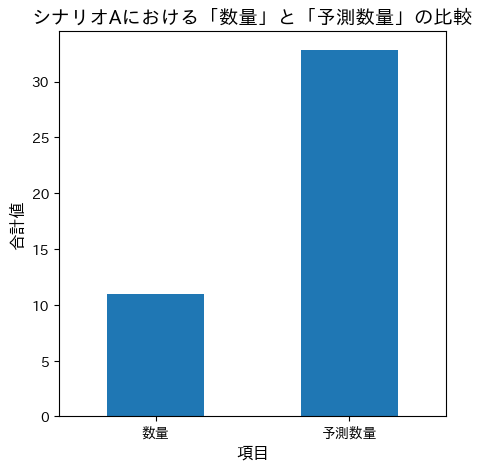

In [25]:
scenario_evaluation.plot_comparison_bar_chart(
    filtered_result,
    ['数量', '予測数量'],
    'シナリオAにおける「数量」と「予測数量」の比較',
    '項目',
    '合計値',
    rotation=0
)

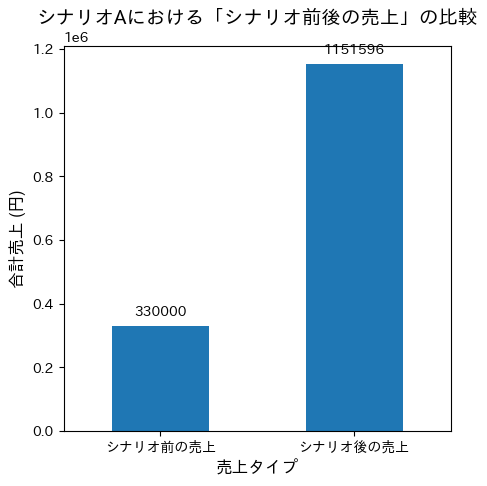

In [29]:
scenario_evaluation.plot_comparison_bar_chart(
    filtered_result,
    ['シナリオ前の売上', 'シナリオ後の売上'],
    'シナリオAにおける「シナリオ前後の売上」の比較',
    '売上タイプ',
    '合計売上 (円)',
    rotation=0,
    show_values=True
)


In [30]:
# result.to_csv('result.csv')

### シナリオB

In [ ]:
compare_adjusted_prices(scenario_A)

In [ ]:
compare_adjusted_prices(scenario_B)

In [ ]:
scenario_A.loc[adjusted_prices_df.index]

In [ ]:
scenario_B.head()

In [ ]:
from scenario_simulation import sim
scenario_B4sim = scenario_B.copy()
selected_columns = ['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']
sim(scenario_B4sim, '/content/24DXbyLifeIsTech/課題04/config.yaml', loaded_model, selected_columns)

In [ ]:
import yaml
from sklearn.preprocessing import LabelEncoder
import numpy as np
# --- 5. config.yaml ファイルからラベルエンコーディング情報を取得 ---
base_dir = '/content/24DXbyLifeIsTech/'
with open(base_dir + '課題04/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

label_encoder_info = config['label_encoding']

# --- 6. 商品カテゴリをラベルエンコーディング ---
le = LabelEncoder()
le.classes_ = np.array(label_encoder_info['商品カテゴリ'])  # リストを numpy 配列に変換
scenario_B['商品カテゴリ'] = le.transform(scenario_B['商品カテゴリ'])

# 商品IDはカテゴリ型に変換
scenario_B['商品ID'] = scenario_B['商品ID'].astype('category')

# --- 結果を確認 ---
scenario_B.head()

In [ ]:
# 価格調整があった行のみを抽出（元の価格とシミュレーション後の商品単価が異なる行）
adjusted_prices_df = scenario_B[scenario_B['元の価格'] != scenario_B['シミュレーション後の商品単価']]

# 調整があったデータを確認
adjusted_prices_df[['商品カテゴリ', '時間帯', '元の価格', 'シミュレーション後の商品単価']]


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation

selected_columns = ['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']

# 説明変数と目的変数に分ける (目的変数は '数量')
X_testB = scenario_B  # 説明変数（テストデータ）
y_testB = scenario_B['数量']  # 目的変数（検証データ）

# テストデータで予測を行う
y_pred_test = loaded_model.predict(X_testB[selected_columns], num_iteration=loaded_model.best_iteration)

# 結果の確認
print(y_pred_test[:10])  # 最初の10件を表示

In [ ]:
scenario_B

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. 売上の計算 ---
# '売上予測' を計算（予測数量 * 商品単価）
scenario_B['売上予測'] = y_pred_test * scenario_B['商品単価']

# '実際の売上' を計算（実際の数量 * 商品単価）
scenario_B['実売上'] = scenario_B['売上']

# --- 2. 売上の変化を確認 ---
# 総売上を計算
total_predicted_sales = scenario_B['売上予測'].sum()
total_actual_sales = scenario_B['実売上'].sum()

# 売上の変化を計算
sales_change = total_predicted_sales - total_actual_sales

# 結果を表示
print(f"予測売上の合計: {total_predicted_sales:.2f}円")
print(f"実売上の合計: {total_actual_sales:.2f}円")
print(f"売上の変化: {sales_change:.2f}円")

# --- 3. 売上の変化を可視化する ---
# 予測売上と実売上を棒グラフで表示
plt.figure(figsize=(10, 6))

# 棒グラフの作成
categories = ['実売上', '予測売上']
values = [total_actual_sales, total_predicted_sales]

plt.bar(categories, values, color=['green', 'blue'])

# グラフのタイトルとラベル
plt.title('実売上と予測売上の比較')
plt.ylabel('売上 (¥)')
plt.grid(True)

# グラフの表示
plt.show()

# --- 4. カテゴリごとの売上比較 ---
# 商品カテゴリごとの予測売上と実売上を計算
category_sales_actual = scenario_B.groupby('商品カテゴリ')['実売上'].sum()
category_sales_predicted = scenario_B.groupby('商品カテゴリ')['売上予測'].sum()

# カテゴリごとの売上比較の棒グラフを作成
plt.figure(figsize=(12, 6))
category_labels = category_sales_actual.index

plt.bar(category_labels, category_sales_actual, width=0.4, label='実売上', align='center', color='green')
plt.bar(category_labels, category_sales_predicted, width=0.4, label='予測売上', align='edge', color='blue')

# グラフのタイトルとラベル
plt.title('商品カテゴリごとの実売上と予測売上の比較')
plt.xlabel('商品カテゴリ')
plt.ylabel('売上 (¥)')
plt.legend()

# グラフの表示
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### シナリオA＋B

In [ ]:
scenario_AB

In [ ]:
import yaml
from sklearn.preprocessing import LabelEncoder
import numpy as np
# --- 5. config.yaml ファイルからラベルエンコーディング情報を取得 ---
base_dir = '/content/24DXbyLifeIsTech/'
with open(base_dir + '課題04/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

label_encoder_info = config['label_encoding']

# --- 6. 商品カテゴリをラベルエンコーディング ---
le = LabelEncoder()
le.classes_ = np.array(label_encoder_info['商品カテゴリ'])  # リストを numpy 配列に変換
scenario_AB['商品カテゴリ'] = le.transform(scenario_AB['商品カテゴリ'])

# 商品IDはカテゴリ型に変換
scenario_AB['商品ID'] = scenario_AB['商品ID'].astype('category')

# --- 結果を確認 ---
scenario_AB.head()

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation

selected_columns = ['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']

# 説明変数と目的変数に分ける (目的変数は '数量')
X_testAB = scenario_AB  # 説明変数（テストデータ）
y_testAB = scenario_AB['数量']  # 目的変数（検証データ）

# テストデータで予測を行う
y_pred_test = loaded_model.predict(X_testAB[selected_columns], num_iteration=loaded_model.best_iteration)

# 結果の確認
print(y_pred_test[:10])  # 最初の10件を表示

In [ ]:
le.inverse_transform(scenario_AB['商品カテゴリ'])


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
scenario_AB['商品カテゴリ'] = le.inverse_transform(scenario_AB['商品カテゴリ'])

# --- 1. 売上の計算 ---
# '売上予測' を計算（予測数量 * 商品単価）
scenario_AB['売上予測'] = y_pred_test * scenario_AB['商品単価']

# '実際の売上' を計算（実際の数量 * 商品単価）
scenario_AB['実売上'] = scenario_AB['売上']

# --- 2. 売上の変化を確認 ---
# 総売上を計算
total_predicted_sales = scenario_AB['売上予測'].sum()
total_actual_sales = scenario_AB['実売上'].sum()

# 売上の変化を計算
sales_change = total_predicted_sales - total_actual_sales

# 結果を表示
print(f"予測売上の合計: {total_predicted_sales:.2f}円")
print(f"実売上の合計: {total_actual_sales:.2f}円")
print(f"売上の変化: {sales_change:.2f}円")

# --- 3. 売上の変化を可視化する ---
# 予測売上と実売上を棒グラフで表示
plt.figure(figsize=(10, 6))

# 棒グラフの作成
categories = ['実売上', '予測売上']
values = [total_actual_sales, total_predicted_sales]

plt.bar(categories, values, color=['green', 'blue'])

# グラフのタイトルとラベル
plt.title('実売上と予測売上の比較')
plt.ylabel('売上 (¥)')
plt.grid(True)

# グラフの表示
plt.show()

# --- 4. カテゴリごとの売上比較 ---
# 商品カテゴリごとの予測売上と実売上を計算
category_sales_actual = scenario_AB.groupby('商品カテゴリ')['実売上'].sum()
category_sales_predicted = scenario_AB.groupby('商品カテゴリ')['売上予測'].sum()

# カテゴリごとの売上比較の棒グラフを作成
plt.figure(figsize=(12, 6))
category_labels = category_sales_actual.index

plt.bar(category_labels, category_sales_actual, width=0.4, label='実売上', align='center', color='green')
plt.bar(category_labels, category_sales_predicted, width=0.4, label='予測売上', align='edge', color='blue')

# グラフのタイトルとラベル
plt.title('商品カテゴリごとの実売上と予測売上の比較')
plt.xlabel('商品カテゴリ')
plt.ylabel('売上 (¥)')
plt.legend()

# グラフの表示
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# 参考資料

# 進捗

1. シミュレーションのためのアルゴリズム実装（[データ分析](https://colab.research.google.com/drive/1UyvZKhMyXKOSDXEnQKm3C3TcXkqjP3QE?usp=sharing)）
1. シミュレーションのためのモデル作成（[機械学習](https://colab.research.google.com/drive/1Wr-ORkKv10t2JLezyU5j9U1fXwcB06iz?usp=sharing)）
1. シミュレーション後の評価方法（シミュレーション：本資料）